با توجه به مقاله می توان گفت در الگوریتم فوروارد فوروارد دیگر تابع لاس کلی در لایه آخر نداریم و در این روش هر لایه دارای یک تابع لاس محلی می باشد که مشتق آن به صورت محلی محاسبه می شود. همچنین با توجه به لاس تعریف شده می توان گفت  این تابع به هر لایه فشار می آورد تا مقادیر بزرگتر از آستانه تعیین شده برای داده های مثبت تولید کند و همچنین مقادیر کوچکتر از آستانه تعیین شده را برای داده های منفی خروجی دهد. بدین ترتیب شروط گوودنس را برآورده می کند.
در پیاده سازی الگوریتم ابتدا یک کلاس برای تعریف هر لایه تعریف کردم سپس یک کلاس برای شبکه یادگیری تعریف کردم. توابع موردنیاز را در کلاس شبکه تعریف کردم. تابع لاس و روش بهینه سازی و محاسبه گوودنس در کلاس لایه انجام شده است . در کلاس شبکه برای هر سری داده گوودنس را برای تمام کلاس ها محاسبه می کنیم . در نهایت کلاسی که بیشترین مقدار گوودنس را دارد انتخاب می شود.

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
import random
import matplotlib.pyplot as plt

In [ ]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.optimizer = Adam(self.parameters(), lr = 0.1)
        self.threshold = 2
        self.epoch_num = 500

    def forward(self, x):
        x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        result = self.relu(torch.mm(x_normalized, self.weight.T) + self.bias.unsqueeze(0))
        return result

    def train(self, x_positive, x_negative):
        for i in range(self.epoch_num):
            positive_data_output = self.forward(x_positive).pow(2).mean(1)
            negative_data_output = self.forward(x_negative).pow(2).mean(1)
            loss = torch.log(1+ torch.exp(torch.cat([self.threshold-positive_data_output,negative_data_output-self.threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            result_positive  = self.forward(x_positive).detach()
            result_negative  = self.forward(x_negative).detach()
        return result_positive, result_negative

In [ ]:
class my_Network(nn.Module):
  def __init__(self, dimension):
    super().__init__()
    self.layers = []
    for i in range(len(dimension)-1):
      self.layers.append(Layer(dimension[i],dimension[i+1]).cuda())

  def input_flatten(self , x):
    return torch.flatten(x)
  # تعریف تابع برای لود کردن دیتاست
  def Load_MNISTdataset(self,batch_size_tr = 50000, batch_size_te = 10000):
    transform = Compose([ToTensor() , self.input_flatten])
    dataset_tr = MNIST(root = './data/', train=True, transform=transform, download=True)
    dataset_te = MNIST(root = './data/', train=False, transform=transform, download=True)
    loader_train = DataLoader(dataset_tr, batch_size=batch_size_tr, shuffle=True)
    loader_test = DataLoader(dataset_te, batch_size=batch_size_te, shuffle=True)
    return loader_train, loader_test
  # تابع های تولید داده های مثبت و منفی
  def generate_positive_data(self,x, y):
    x_positive = x.clone()
    max_value = x_positive.max()
    x_positive[:, :10] = x_positive[:, :10] * 0
    x_positive[range(x.shape[0]), y] = max_value
    return x_positive
  def generate_negative_data(self,x):
    y = torch.randint(10, (x.shape[0],))
    x_negative = x.clone()
    max_value = x_negative.max()
    x_negative[:, :10] = x_negative[:, :10] * 0
    x_negative[range(x.shape[0]), y] = max_value
    return x_negative

  def predict(self, x):
    goodness_score_forlabel = []
    for i in range(10):
      h = self.generate_positive_data(x, i)
      goodness = []
      for j in self.layers:
        h = j(h)
        goodness = goodness + [h.pow(2).mean(1)]
      goodness_score_forlabel = goodness_score_forlabel + [sum(goodness).unsqueeze(1)]
    goodness_score_forlabel = torch.cat(goodness_score_forlabel, 1)
    result = goodness_score_forlabel.argmax(1)
    return result

  def train(self, x_positive, x_negative):
    h_positive = x_positive
    h_negative = x_negative
    for i, j in enumerate(self.layers):
      print('training layer', i, '...')
      h_positive, h_negative = j.train(h_positive, h_negative)

In [ ]:
# آموزش مدل تعریف شده با دیتاست موردنظر و گزارش دقت مدل روی داده های آموزش و داده های تست
my_Forward_Forward_model = my_Network([784,500,300,100])
load_tr, load_te = my_Forward_Forward_model.Load_MNISTdataset()
for x, y in load_tr:
  x = x.cuda()
  y = y.cuda()
  positive_data = my_Forward_Forward_model.generate_positive_data(x, y)
  negative_data = my_Forward_Forward_model.generate_negative_data(x)
  my_Forward_Forward_model.train(positive_data, negative_data)
  predictionTrain = my_Forward_Forward_model.predict(x)
  predictions_tr = (predictionTrain == y).sum().item()
  num_l = y.shape[0]
  accuracy_tr = predictions_tr / num_l
  print('accuracy of Forward Forward Algorithm on Train set:', accuracy_tr)
  print('Error of Forward Forward Algorithm on Train set:', 1 - accuracy_tr)
  break
for x_test,y_test in load_te:
  x_test = x_test.cuda()
  y_test = y_test.cuda()
  predictionTest = my_Forward_Forward_model.predict(x_test)
  predictions_te = (predictionTest == y_test).sum().item()
  num_l_ = y_test.shape[0]
  accuracy_te = predictions_te / num_l_
  print('accuracy of Forward Forward Algorithm on Test set:', accuracy_te)
  print('Error of Forward Forward Algorithm on Test set:', 1 - accuracy_te)
  break

training layer 0 ...
training layer 1 ...
training layer 2 ...
accuracy of Forward Forward Algorithm on Train set: 0.90426
Error of Forward Forward Algorithm on Train set: 0.09574000000000005
accuracy of Forward Forward Algorithm on Test set: 0.9029
Error of Forward Forward Algorithm on Test set: 0.09709999999999996


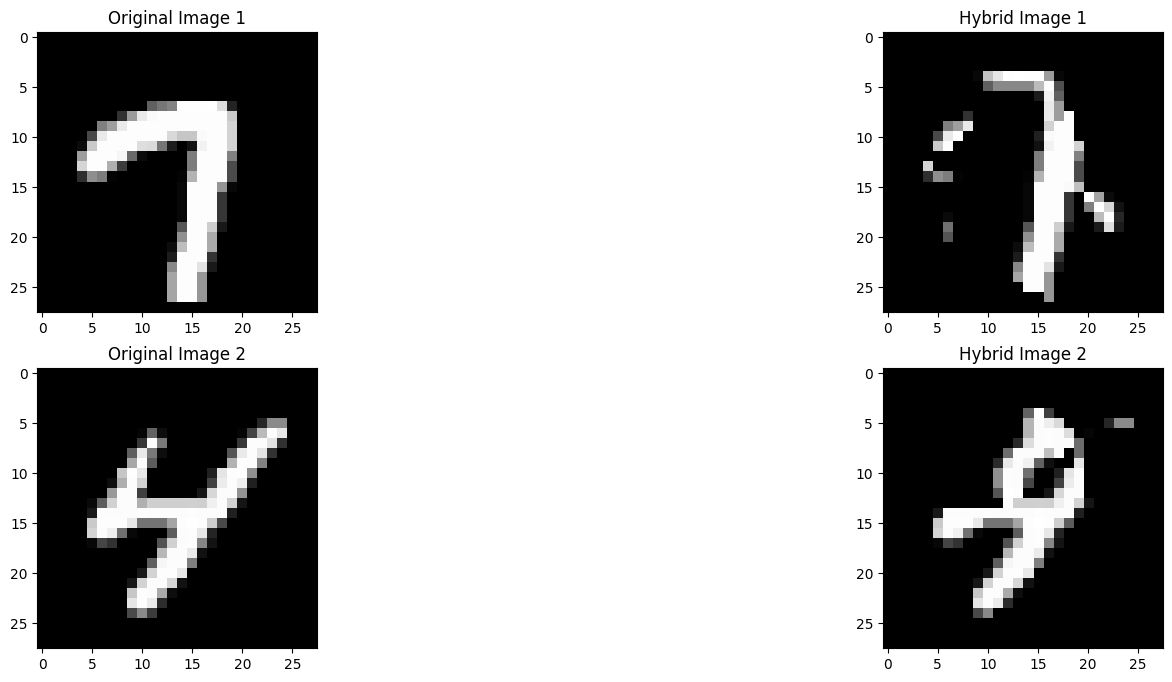

In [ ]:
# این بخش برای قسمت دوم سوال می باشد
# دیتاست را لود کردم
train_dataset = MNIST(root = "./data/",download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root = "./data/",download=True, train=False, transform=ToTensor())
loader_tr = DataLoader(train_dataset, batch_size=1000, shuffle=True)
loader_te = DataLoader(test_dataset, batch_size=1000, shuffle=True)

# تعریف تابع برای تولید ماسک به روش گفته شده در مقاله
def generate_mask():
    random_image = torch.randint(2, size=(1, 1, 28, 28), dtype=torch.float32)
    blur_kernel = torch.tensor([[1/4, 1/2, 1/4], [1/2, 1, 1/2], [1/4, 1/2, 1/4]]) / 4
    blur_kernel = blur_kernel.view(1, 1, 3, 3)
    for i in range(5):
        random_image = torch.nn.functional.conv2d(random_image, blur_kernel, padding='same')
    mask = (random_image > 0.5).float().squeeze()
    return mask
# تولید داده های هیبرید به روش گفته شده در مقاله
def generate_hybrid_data(x):
    i = torch.randperm(x.shape[0])
    first_sample = x
    second_sample = x[i]
    mask = generate_mask()
    new_first_sample = first_sample * mask
    new_second_sample = second_sample * (1 - mask)
    hybrid_image = new_first_sample + new_second_sample
    return hybrid_image
# دو نمونه از داده های اصلی و دو نمونه از داده هیبرد تولید شده در این قسمت نشان داده شده است
for x, y in loader_tr:
    hybrid_data = generate_hybrid_data(x)
    original_image1 = x[0]
    original_image2 = x[1]
    hybrid_image1 = hybrid_data[0]
    hybrid_image2 = hybrid_data[1]
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(original_image1.squeeze(), cmap='gray')
    plt.title("Original Image 1")
    plt.subplot(2, 2, 2)
    plt.imshow(hybrid_image1.squeeze(), cmap='gray')
    plt.title("Hybrid Image 1")
    plt.subplot(2, 2, 3)
    plt.imshow(original_image2.squeeze(), cmap='gray')
    plt.title("Original Image 2")
    plt.subplot(2, 2, 4)
    plt.imshow(hybrid_image2.squeeze(), cmap='gray')
    plt.title("Hybrid Image 2")
    plt.show()
    break
